# Random Forest Baseline

Train a RandomForestClassifier on the existing feature set for a tree-based baseline with cross-validation, holdout evaluation, and feature importance visualization.


In [4]:
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
)

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


In [5]:
FEATURES = ['year', 'round', 'avg_race_lap_time_s', 'quali_position', 'prev_points_total']
TARGET = 'scored_points'
data_path = Path('data/grandprix_features.csv')

df_model = pd.read_csv(data_path)

print(f"Rows after cleaning: {len(df_model)}")
df_model.head()


Rows after cleaning: 300


,year,round,event,driver,team,quali_position,avg_race_lap_time_s,finish_position,points_awarded,prev_points_total,scored_points
0,2022,1,Bahrain Grand Prix,LEC,Ferrari,1,97.604208,1.0,26.0,0.0,1
1,2022,1,Bahrain Grand Prix,SAI,Ferrari,3,98.079957,2.0,18.0,0.0,1
2,2022,1,Bahrain Grand Prix,HAM,Mercedes,5,98.266244,3.0,15.0,0.0,1
3,2022,1,Bahrain Grand Prix,RUS,Mercedes,9,98.639022,4.0,12.0,0.0,1
4,2022,1,Bahrain Grand Prix,MAG,Haas F1 Team,7,98.852833,5.0,10.0,0.0,1


In [6]:
X = df_model[FEATURES]
y = df_model[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((240, 5), (60, 5))

Pipeline: Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=400, n_jobs=-1,
                                        random_state=42))])
CV ROC-AUC: 0.777 ± 0.049
CV PR-AUC (avg precision): 0.793 ± 0.070

Holdout classification report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        30
           1       0.75      0.80      0.77        30

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60

Holdout ROC-AUC: 0.8277777777777778
Holdout PR-AUC (avg precision): 0.8105415464460386

Additional metrics:
Precision: 0.75
Recall: 0.8
F1 (binary): 0.7741935483870968
F1 (macro): 0.7664071190211346
Confusion matrix (raw):
 [[22  8]
 [ 6 24]]

Confusion matr

,Pred 0,Pred 1
Actual 0,22,8
Actual 1,6,24


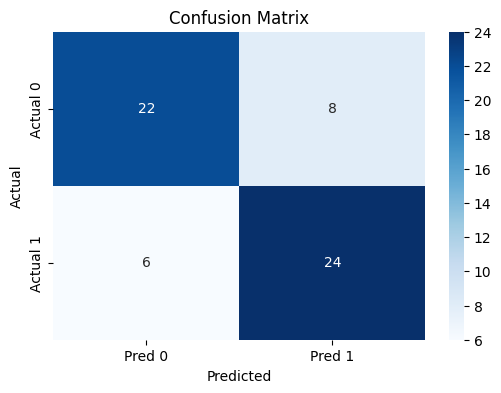

In [7]:
# Random forest baseline (imputer + tree ensemble)
rf = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        n_jobs=-1,
        random_state=42,
        class_weight='balanced',
    ),
)
print('Pipeline:', rf)

# Cross-validation: ROC-AUC and PR-AUC (average_precision)
cv_auc = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
cv_pr = cross_val_score(rf, X_train, y_train, cv=5, scoring='average_precision')
print(f'CV ROC-AUC: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}')
print(f'CV PR-AUC (avg precision): {cv_pr.mean():.3f} ± {cv_pr.std():.3f}')

# Fit on training data
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Holdout evaluation
print('\nHoldout classification report:')
print(classification_report(y_test, y_pred))
print('Holdout ROC-AUC:', roc_auc_score(y_test, y_proba))
print('Holdout PR-AUC (avg precision):', average_precision_score(y_test, y_proba))
print('\nAdditional metrics:')
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 (binary):', f1_score(y_test, y_pred))
print('F1 (macro):', f1_score(y_test, y_pred, average='macro'))

# Confusion matrix (numeric) and visualization
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix (raw):\n', cm)

cm_df = pd.DataFrame(
    cm,
    index=[f'Actual {i}' for i in range(cm.shape[0])],
    columns=[f'Pred {i}' for i in range(cm.shape[1])],
)

print('\nConfusion matrix as table:')
display(cm_df)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
